In [1]:
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, linewidth=0.5, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [16]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial
from einops import rearrange
from math import sqrt

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))


class DsConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias=bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

class EfficientSelfAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        heads,
        reduction_ratio
    ):
        super().__init__()
        self.scale = (dim // heads) ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(dim, dim, 1, bias = False)
        self.to_kv = nn.Conv2d(dim, dim * 2, reduction_ratio, stride = reduction_ratio, bias = False)
        self.to_out = nn.Conv2d(dim, dim, 1, bias = False)

    def forward(self, x):
        h, w = x.shape[-2:]
        heads = self.heads

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = heads), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) c -> b (h c) x y', h = heads, x = h, y = w)
        return self.to_out(out)

class MixFeedForward(nn.Module):
    def __init__(
        self,
        *,
        dim,
        expansion_factor
    ):
        super().__init__()
        hidden_dim = dim * expansion_factor
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            DsConv2d(hidden_dim, hidden_dim, 3, padding = 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1)
        )

    def forward(self, x):
        return self.net(x)

'''
5. MiT (Mixer Transformer)
이미지를 여러 스테이지로 처리합니다. 각 스테이지는 이미지를 패치로 나누고, 패치를 임베딩한 후, 여러 개의 Transformer 레이어를 적용합니다.
이 과정은 이미지의 다양한 해상도에서 특징을 추출합니다. 
'''    
class MiT(nn.Module):
    def __init__(
        self,
        *,
        channels,
        dims,
        heads,
        ff_expansion,
        reduction_ratio,
        num_layers,
        stage_kernel_stride_pad = ((7, 4, 3),  
                                   (3, 2, 1), 
                                   (3, 2, 1), 
                                   (3, 2, 1))
    ):
        super().__init__()


        dims = (channels, *dims)
        dim_pairs = list(zip(dims[:-1], dims[1:]))

        self.stages = nn.ModuleList([])

        for (dim_in, dim_out), (kernel, stride, padding), num_layers, ff_expansion, heads, reduction_ratio in zip(
            dim_pairs, stage_kernel_stride_pad, num_layers, ff_expansion, heads, reduction_ratio):
            #여기서 너비와 높이가 같은 정사각형 패치를 사용합니다.
            get_overlap_patches = nn.Unfold(kernel, stride = stride, padding = padding)
            overlap_patch_embed = nn.Conv2d(dim_in * kernel ** 2, dim_out, 1)

            layers = nn.ModuleList([])

            for _ in range(num_layers):
                layers.append(nn.ModuleList([
                    PreNorm(dim_out, EfficientSelfAttention(dim = dim_out, heads = heads, reduction_ratio = reduction_ratio)),
                    PreNorm(dim_out, MixFeedForward(dim = dim_out, expansion_factor = ff_expansion)),
                ]))

            self.stages.append(nn.ModuleList([
                get_overlap_patches,
                overlap_patch_embed,
                layers
            ]))

    def forward(
        self,
        x,
        return_layer_outputs = False
    ):
        h, w = x.shape[-2:]

        layer_outputs = []
        for (get_overlap_patches, overlap_embed, layers) in self.stages:
            x = get_overlap_patches(x)

            num_patches = x.shape[-1]
            ratio = int(sqrt((h * w) / num_patches))
            x = rearrange(x, 'b c (h w) -> b c h w', h = h // ratio)

            x = overlap_embed(x)
            for (attn, ff) in layers:
                x = attn(x) + x
                x = ff(x) + x

            layer_outputs.append(x)

        ret = x if not return_layer_outputs else layer_outputs
        return ret
    
class Head(nn.Module):
    def __init__(self, input_dim = 256 ,dim=128, num_classes=11):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_dim , dim, kernel_size=1),  
            nn.Conv2d(dim, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x)
## 디코더
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class Decoder(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(Decoder, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ARC_Net(nn.Module):
    def __init__(
        self,
        *,
        dims=(64,128),
        heads=(4, 8),
        ff_expansion=(4, 4),
        reduction_ratio=(2, 1),
        num_layers=4,
        channels=1,
        num_classes=11,
        kernel_stride_padding=((1, 1, 0), (3, 1, 1))
    ) -> None:
        super().__init__()
        dims, heads, ff_expansion, reduction_ratio, num_layers = map(
            partial(cast_tuple, depth=4), (dims, heads, ff_expansion, reduction_ratio, num_layers))
        decoder_dim = dims[-1]
        # 입력은 튜플로 받아서 각 스테이지에 대해 커널 크기, 스트라이드, 패딩을 설정할 수 있습니다.
        self.mit = MiT(
            channels=channels,
            dims=dims,
            heads=heads,
            ff_expansion=ff_expansion,
            reduction_ratio=reduction_ratio,
            num_layers=num_layers
        )

        self.to_fused = nn.ModuleList([nn.Sequential(
            nn.Conv2d(dim, decoder_dim, 1),
            nn.Upsample(scale_factor=2 ** i)
        ) for i, dim in enumerate(dims)])
        
        self.decoder = Decoder(gate_channels = decoder_dim * len(kernel_stride_padding))  
        self.head = Head(input_dim=decoder_dim * len(kernel_stride_padding), dim=decoder_dim, num_classes=num_classes)

    def forward(self, x):
        layer_outputs = self.mit(x, return_layer_outputs=True) #return tpye: List
        fused = [self.decoder(to_fused(output)) for output, to_fused in zip(layer_outputs, self.to_fused)]
        
        # 다양한 커널 크기에서 추출된 특징을 병합
        fused = torch.cat(fused, dim=1)

        
        # 병합된 특징을 헤드에 전달
        fused = self.head(fused)
        return fused

In [11]:
# 모델 생성 및 출력
model_args = {
    'dims': (64, 128),
    'heads': (4, 8),
    'ff_expansion': (4, 4),
    'reduction_ratio': (2, 1),
    'num_layers': 4,
    'channels': 1,
    'num_classes': 11,
    'kernel_stride_padding': ((1, 1, 0),(3, 1, 1))
    }

In [12]:
dims, heads, ff_expansion, reduction_ratio, num_layers = map(
            partial(cast_tuple, depth=4), (model_args['dims'], 
                                           model_args['heads'], 
                                           model_args['ff_expansion'], 
                                           model_args['reduction_ratio'], 
                                           model_args['num_layers']))
mit = MiT(
        dims=dims,
        heads=heads,
        ff_expansion=ff_expansion,
        reduction_ratio=reduction_ratio,
        num_layers=num_layers,
        channels=model_args['channels'],
        stage_kernel_stride_pad=model_args['kernel_stride_padding']
          )
x = torch.randn(10, 1, 30, 30)

print("Input shape:", x.shape)
print("Output shape:", mit(x).shape)

Input shape: torch.Size([10, 1, 30, 30])
Output shape: torch.Size([10, 128, 30, 30])


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ARC_Net(**model_args).to(device)
# 입력 텐서 생성
x = torch.randn(10, 1, 30, 30).to(device)

print(model(x).shape)

EinopsError:  Error while processing rearrange-reduction pattern "b c (h w) -> b c h w".
 Input tensor shape: torch.Size([10, 49, 64]). Additional info: {'h': 10}.
 Shape mismatch, can't divide axis of length 64 in chunks of 10

In [6]:
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
outer_model = ARC_Net(**model_args).to(device)

# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(outer_model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")
from torchinfo import summary

summary(outer_model, input_size=(1, 1, 30, 30))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
FLOPs: 77.421M
파라미터 수: 87.667K


Layer (type:depth-idx)                                       Output Shape              Param #
ARC_Net                                                      [1, 11, 30, 30]           --
├─ModuleList: 1-1                                            --                        --
│    └─ModuleList: 2-1                                       --                        --
│    │    └─Embedding: 3-1                                   [1, 32, 30, 30]           64
│    │    └─Encoder: 3-2                                     [1, 32, 30, 30]           63,200
│    └─ModuleList: 2-2                                       --                        --
│    │    └─Embedding: 3-3                                   [1, 32, 30, 30]           320
│    │    └─Encoder: 3-4                                     [1, 32, 30, 30]           63,200
├─Decoder: 1-2                                               [1, 64, 30, 30]           --
│    └─ChannelGate: 2-3                                      [1, 64, 30, 30]          

In [7]:
# from bw_net_maml import BWNet_MAML

# model = BWNet_MAML(embed_size=1).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

In [8]:
import torch
#weight = torch.ones(11).to('cuda')
#weight[0] = 0.0005  # 0은 무시
#print(weight)

Train Loop
N개의 샘플 배치를 불러온다.
1. 각 샘플에 대해 이너 모델을 아우터 모델에서 복사해 로스를 계산한다.
2. 이너 모델의 파라미터를 업데이트한다.
3. 업데이트 된 이너 모델을 바탕으로 테스크 셋에 대한 로스를 계산한다.
4. 테스크 셋에 대한 로스를 저장한다.
5. 모든 테스크 셋에 대해 로스가 구해지면 아우터 모델의 파라미터를 업데이트한다.

Using cuda device
Epoch 1/500


Validation:  89%|████████▉ | 8/9 [04:52<00:34, 34.93s/it]

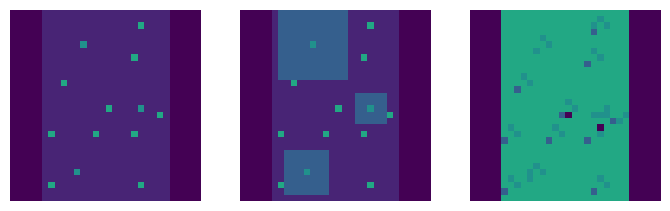

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.05s/it]


Epoch 1/500, Loss: 2.116229466293763, Accuracy: 26.507638430695835%
Epoch 2/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.02s/it]

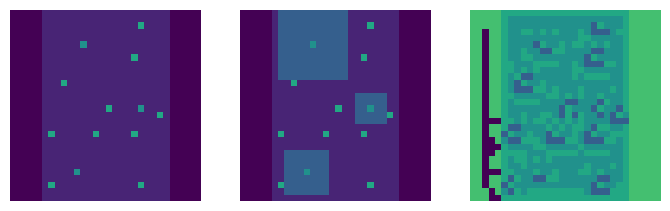

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.94s/it]


Epoch 2/500, Loss: 2.1087587421719953, Accuracy: 26.94818048012993%
Epoch 3/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.87s/it]

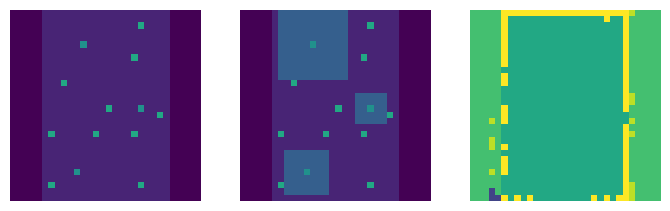

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.87s/it]


Epoch 3/500, Loss: 2.1481353237264766, Accuracy: 27.730802415875754%
Epoch 4/500


Validation:  89%|████████▉ | 8/9 [04:50<00:35, 35.06s/it]

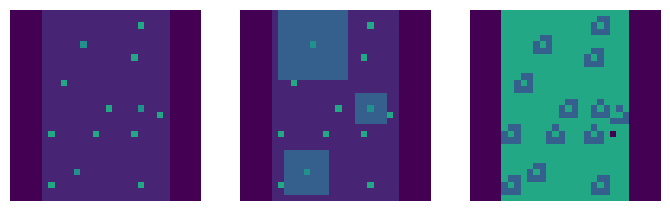

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.85s/it]


Epoch 4/500, Loss: 2.1755574512026477, Accuracy: 27.71557630817642%
Epoch 5/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.85s/it]

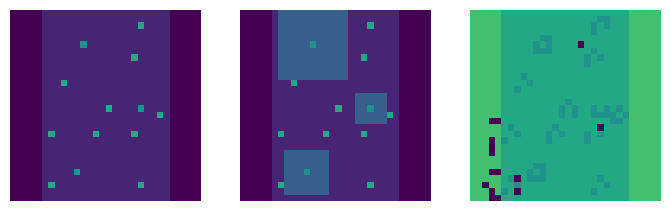

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.91s/it]


Epoch 5/500, Loss: 2.1351742800636337, Accuracy: 26.00720702431102%
Epoch 6/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.99s/it]

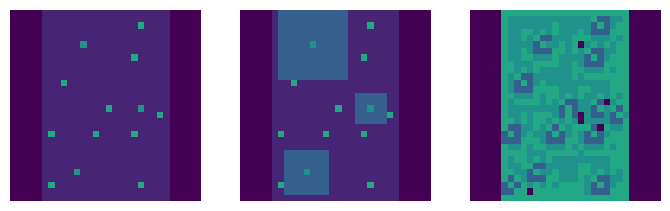

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.98s/it]


Epoch 6/500, Loss: 2.144118515290053, Accuracy: 27.401918489570118%
Epoch 7/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.88s/it]

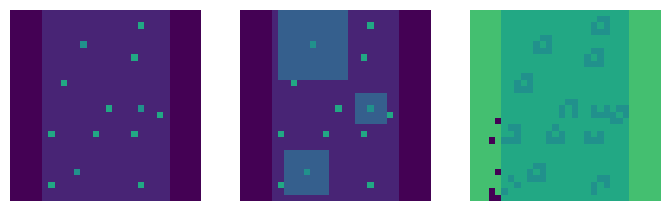

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.88s/it]


Epoch 7/500, Loss: 2.1026872625854534, Accuracy: 26.997919098614425%
Epoch 8/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.07s/it]

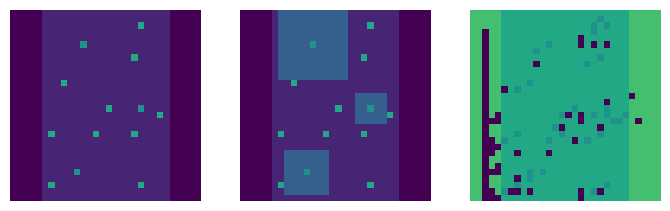

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.98s/it]


Epoch 8/500, Loss: 2.1312611006324786, Accuracy: 28.23630919149368%
Epoch 9/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.91s/it]

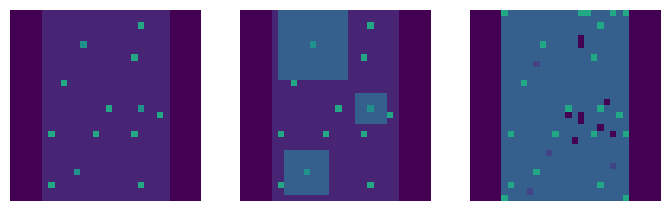

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.88s/it]


Epoch 9/500, Loss: 2.136181833209172, Accuracy: 27.825204283611633%
Epoch 10/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.03s/it]

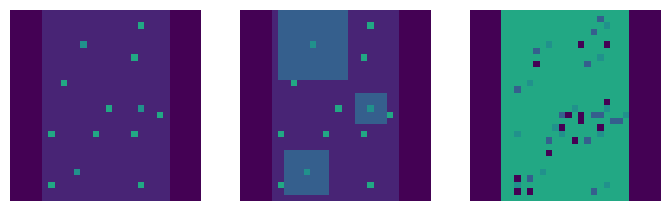

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.95s/it]


Epoch 10/500, Loss: 2.1489071380836013, Accuracy: 26.69745724001421%
Epoch 11/500


Validation:  89%|████████▉ | 8/9 [04:50<00:34, 34.80s/it]

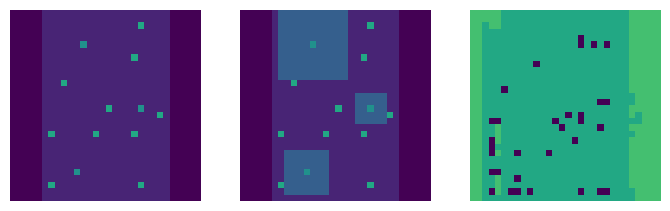

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.85s/it]


Epoch 11/500, Loss: 2.1446348016899353, Accuracy: 28.63421813936964%
Epoch 12/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.01s/it]

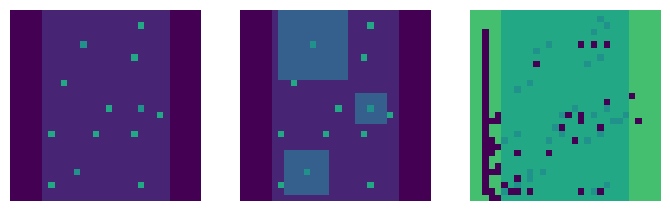

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.95s/it]


Epoch 12/500, Loss: 2.1482304124815084, Accuracy: 25.66918743338578%
Epoch 13/500


Validation:  89%|████████▉ | 8/9 [04:54<00:35, 35.09s/it]

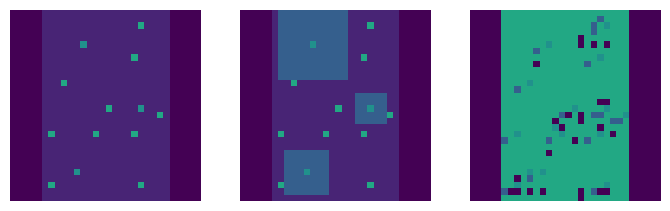

Validation: 100%|██████████| 9/9 [05:08<00:00, 34.24s/it]


Epoch 13/500, Loss: 2.200127574666303, Accuracy: 27.214129827944983%
Epoch 14/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.92s/it]

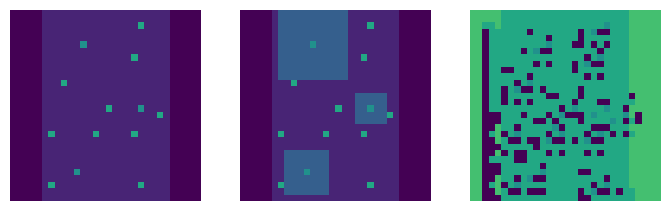

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.96s/it]


Epoch 14/500, Loss: 2.115967250240162, Accuracy: 28.21397756686799%
Epoch 15/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.95s/it]

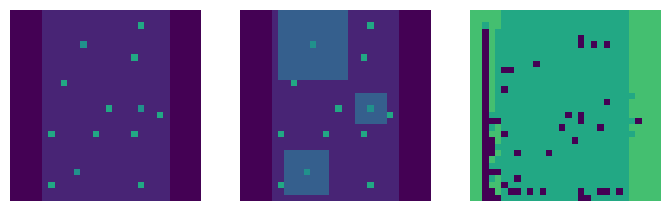

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.92s/it]


Epoch 15/500, Loss: 2.180235624455609, Accuracy: 27.26082322488961%
Epoch 16/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.03s/it]

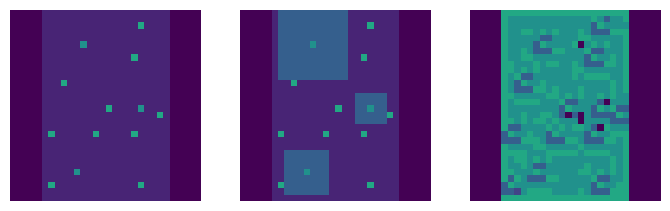

Validation: 100%|██████████| 9/9 [05:05<00:00, 34.00s/it]


Epoch 16/500, Loss: 2.145492803901078, Accuracy: 28.146982692990914%
Epoch 17/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.13s/it]

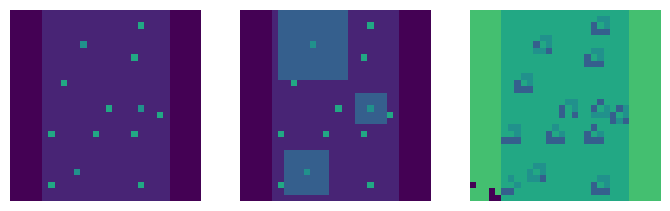

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.94s/it]


Epoch 17/500, Loss: 2.134090376924501, Accuracy: 27.930771963660355%
Epoch 18/500


Validation:  89%|████████▉ | 8/9 [04:50<00:34, 34.82s/it]

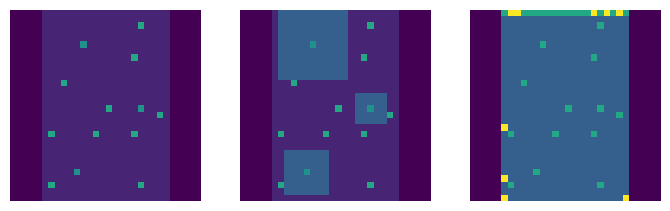

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.85s/it]


Epoch 18/500, Loss: 2.1154188259831477, Accuracy: 25.135258590062428%
Epoch 19/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.10s/it]

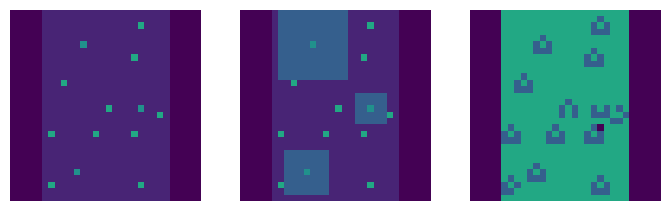

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.96s/it]


Epoch 19/500, Loss: 2.1364155226078125, Accuracy: 28.222098157640968%
Epoch 20/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.03s/it]

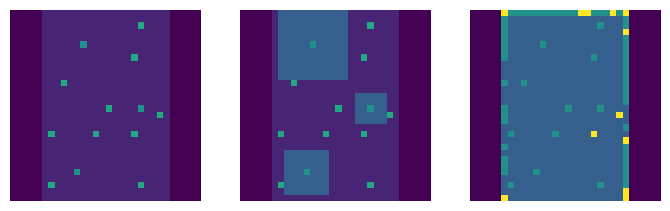

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.05s/it]


Epoch 20/500, Loss: 2.1110797692312544, Accuracy: 28.088108409886818%
Epoch 21/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 35.00s/it]

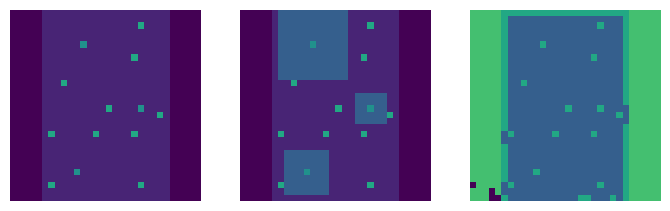

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.92s/it]


Epoch 21/500, Loss: 2.1102274139200587, Accuracy: 28.567223265492565%
Epoch 22/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.92s/it]

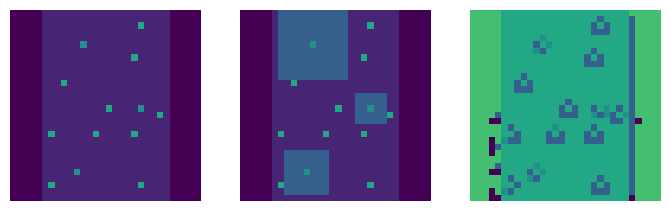

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.88s/it]


Epoch 22/500, Loss: 2.1953858435865232, Accuracy: 27.551134345023602%
Epoch 23/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.97s/it]

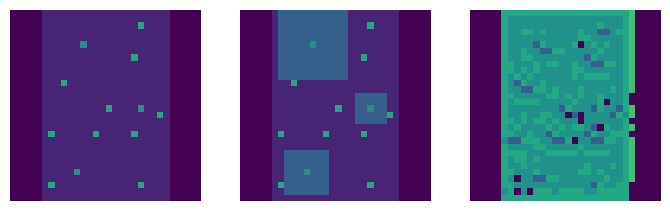

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.89s/it]


Epoch 23/500, Loss: 2.192014455012888, Accuracy: 26.637567883063493%
Epoch 24/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.94s/it]

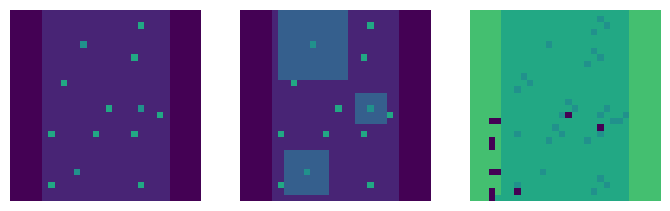

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.88s/it]


Epoch 24/500, Loss: 2.2322351005737424, Accuracy: 26.260975485966604%
Epoch 25/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.06s/it]

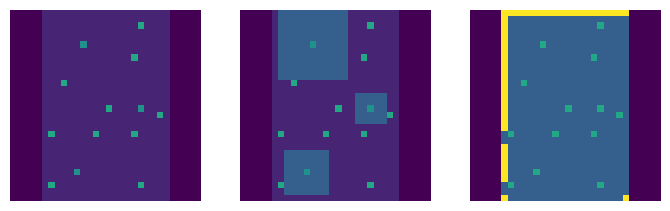

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.96s/it]


Epoch 25/500, Loss: 2.150845980231688, Accuracy: 27.91047048672791%
Epoch 26/500


Validation:  89%|████████▉ | 8/9 [04:50<00:34, 34.88s/it]

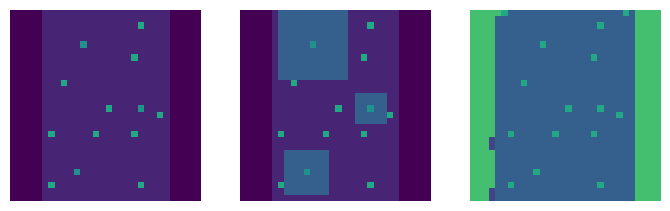

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.87s/it]


Epoch 26/500, Loss: 2.1352066053410987, Accuracy: 27.140029437141553%
Epoch 27/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.90s/it]

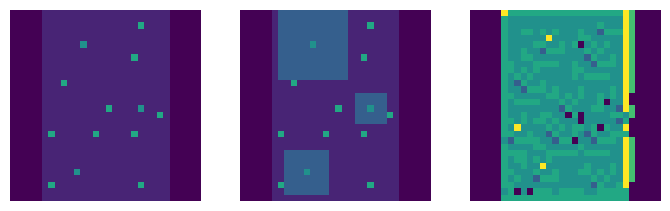

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.89s/it]


Epoch 27/500, Loss: 2.1365150378256823, Accuracy: 25.973709587372483%
Epoch 28/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.93s/it]

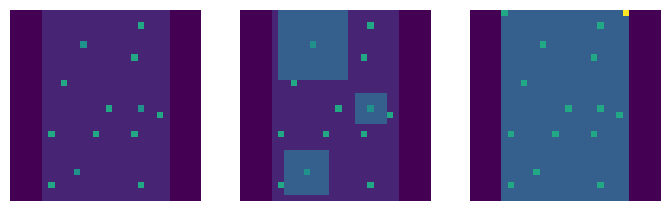

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.92s/it]


Epoch 28/500, Loss: 2.0974997956314634, Accuracy: 28.31853017307009%
Epoch 29/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.92s/it]

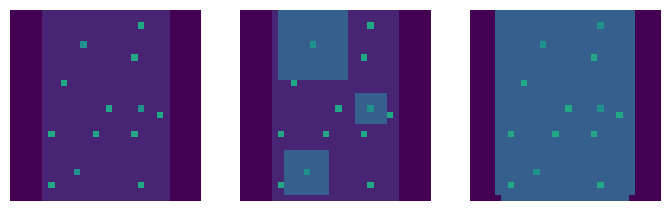

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.93s/it]


Epoch 29/500, Loss: 2.1294636397060174, Accuracy: 27.574481043495915%
Epoch 30/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.23s/it]

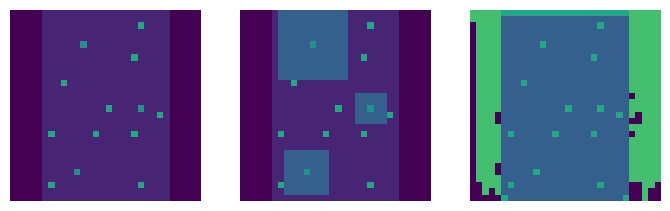

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.01s/it]


Epoch 30/500, Loss: 2.1400775102129415, Accuracy: 28.43526366543166%
Epoch 31/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.01s/it]

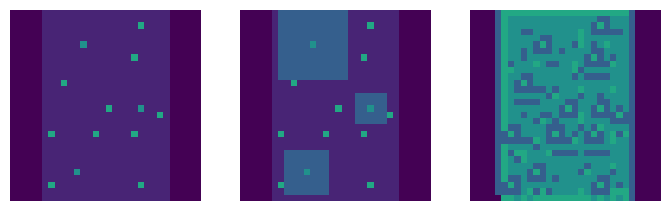

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.02s/it]


Epoch 31/500, Loss: 2.18202246017843, Accuracy: 28.201796680708522%
Epoch 32/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.26s/it]

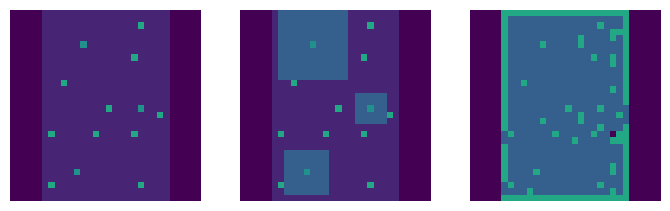

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.07s/it]


Epoch 32/500, Loss: 2.0995725389027653, Accuracy: 26.297518144445007%
Epoch 33/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.87s/it]

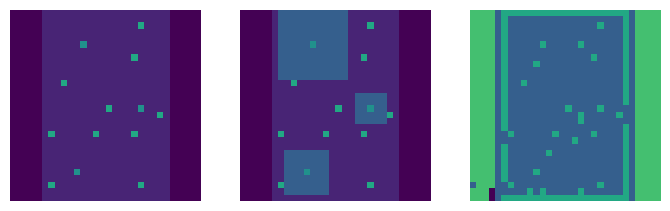

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.94s/it]


Epoch 33/500, Loss: 2.11863668238064, Accuracy: 27.530832868091153%
Epoch 34/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.12s/it]

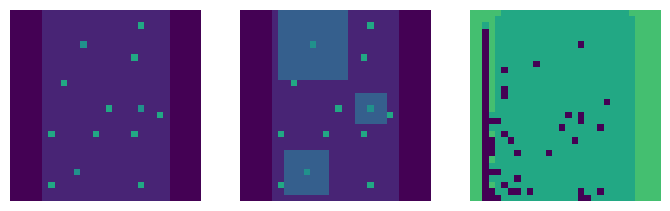

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.01s/it]


Epoch 34/500, Loss: 2.196045599433289, Accuracy: 27.024311018626605%
Epoch 35/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.97s/it]

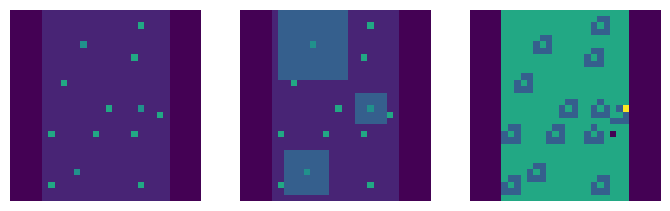

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.93s/it]


Epoch 35/500, Loss: 2.1133624687257417, Accuracy: 27.748058671268335%
Epoch 36/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.02s/it]

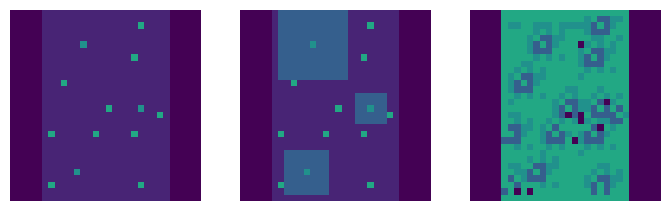

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.95s/it]


Epoch 36/500, Loss: 2.163256194326929, Accuracy: 27.000964320154292%
Epoch 37/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.04s/it]

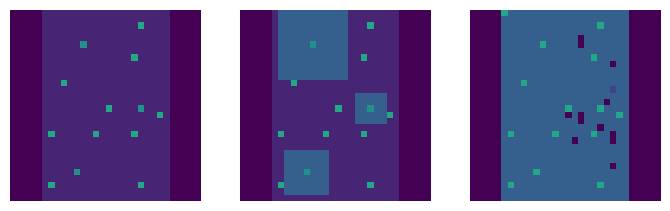

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.94s/it]


Epoch 37/500, Loss: 2.1471575058303185, Accuracy: 27.389737603410648%
Epoch 38/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.91s/it]

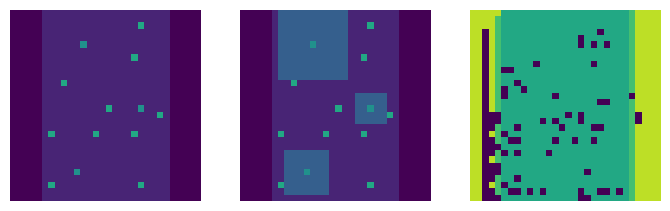

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.89s/it]


Epoch 38/500, Loss: 2.1310070537581933, Accuracy: 26.487336953763386%
Epoch 39/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.92s/it]

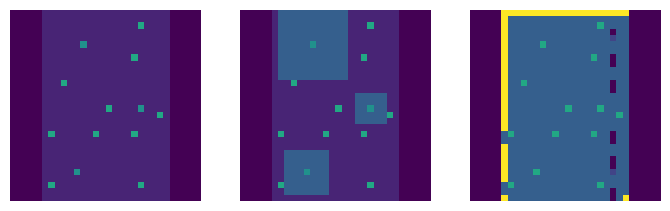

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.93s/it]


Epoch 39/500, Loss: 2.1424808445651093, Accuracy: 26.760391818504797%
Epoch 40/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.08s/it]

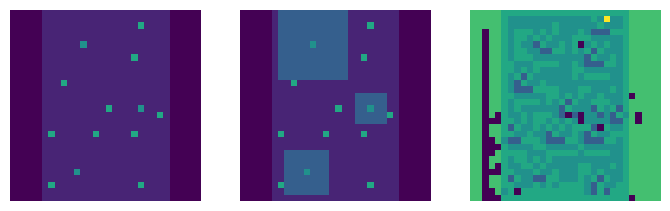

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.05s/it]


Epoch 40/500, Loss: 2.097931771901456, Accuracy: 26.67614068923514%
Epoch 41/500


Validation:  89%|████████▉ | 8/9 [04:50<00:34, 34.85s/it]

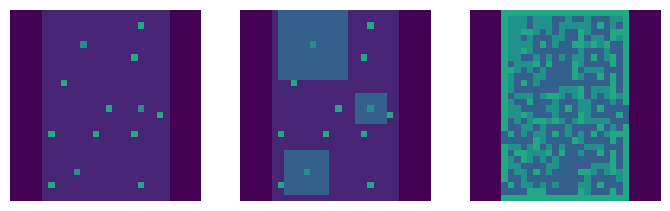

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.82s/it]


Epoch 41/500, Loss: 2.1066718104346553, Accuracy: 26.424402375272802%
Epoch 42/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.98s/it]

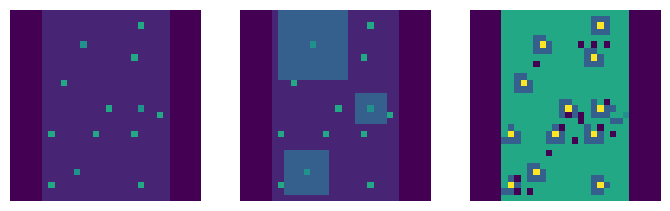

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.95s/it]


Epoch 42/500, Loss: 2.2063645602410618, Accuracy: 26.99994924630767%
Epoch 43/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.09s/it]

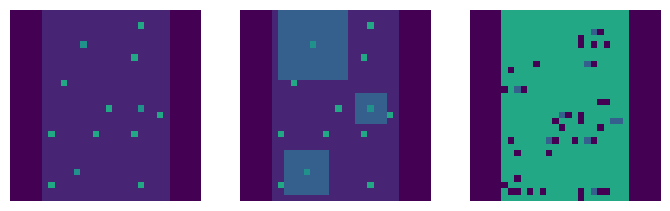

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.01s/it]


Epoch 43/500, Loss: 2.1919214129447937, Accuracy: 26.85682383393392%
Epoch 44/500


Validation:  89%|████████▉ | 8/9 [04:52<00:34, 34.90s/it]

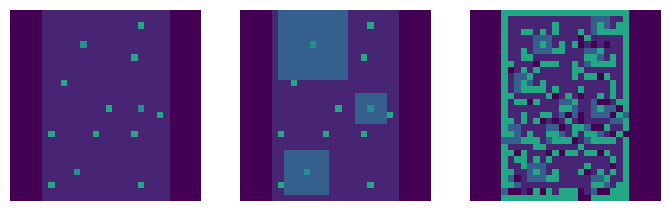

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.99s/it]


Epoch 44/500, Loss: 2.128905140272473, Accuracy: 26.89641171395219%
Epoch 45/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.15s/it]

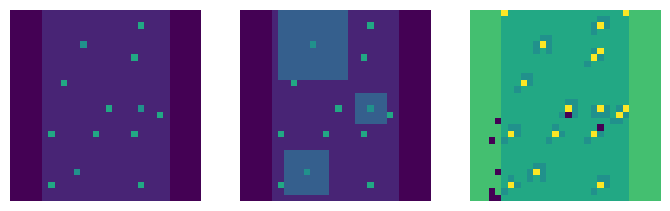

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.96s/it]


Epoch 45/500, Loss: 2.171715948063889, Accuracy: 26.740090341572348%
Epoch 46/500


Validation:  89%|████████▉ | 8/9 [04:53<00:35, 35.14s/it]

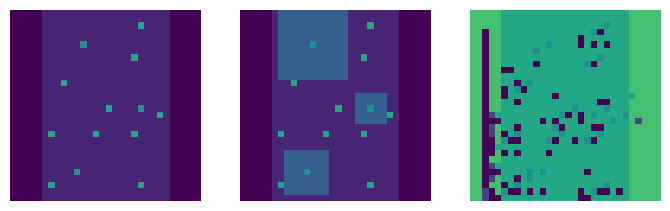

Validation: 100%|██████████| 9/9 [05:07<00:00, 34.13s/it]


Epoch 46/500, Loss: 2.1549437870060344, Accuracy: 27.48210932345328%
Epoch 47/500


Validation:  89%|████████▉ | 8/9 [04:51<00:35, 35.07s/it]

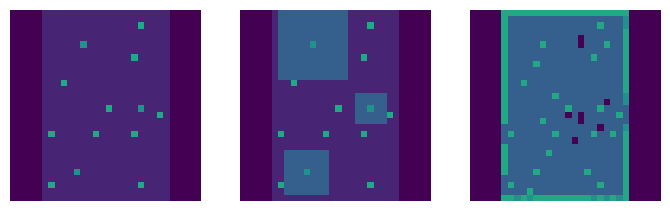

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.99s/it]


Epoch 47/500, Loss: 2.194330775510155, Accuracy: 27.91047048672791%
Epoch 48/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.89s/it]

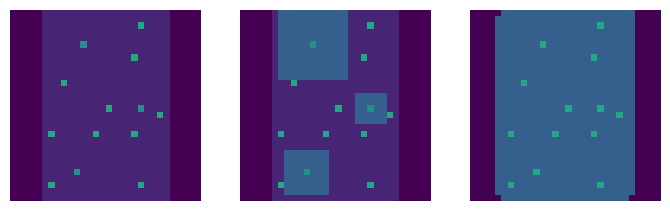

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.89s/it]


Epoch 48/500, Loss: 2.1383698973849166, Accuracy: 28.455565142364108%
Epoch 49/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.09s/it]

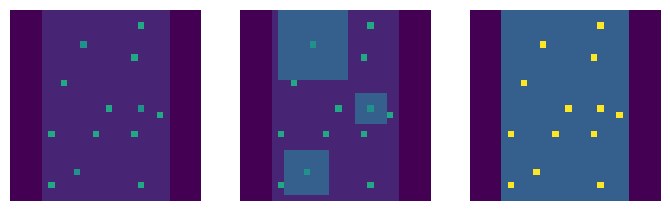

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.00s/it]


Epoch 49/500, Loss: 2.209249409329066, Accuracy: 27.69019946201086%
Epoch 50/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.98s/it]

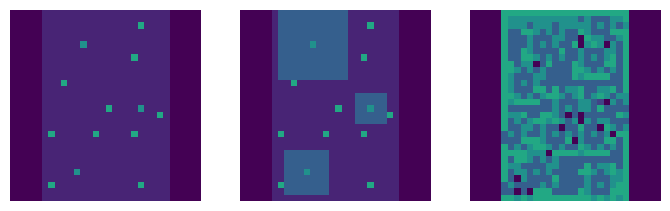

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.94s/it]


Epoch 50/500, Loss: 2.1647356777743108, Accuracy: 28.11856062528549%
Epoch 51/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 35.00s/it]

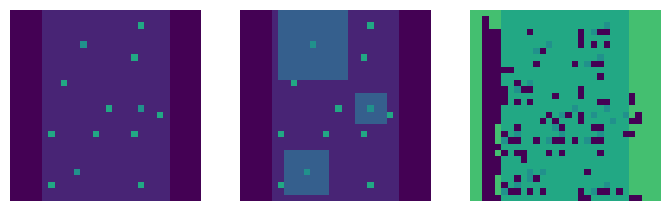

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.98s/it]


Epoch 51/500, Loss: 2.1686616211347194, Accuracy: 27.91554585596102%
Epoch 52/500


Validation:  89%|████████▉ | 8/9 [04:51<00:34, 34.96s/it]

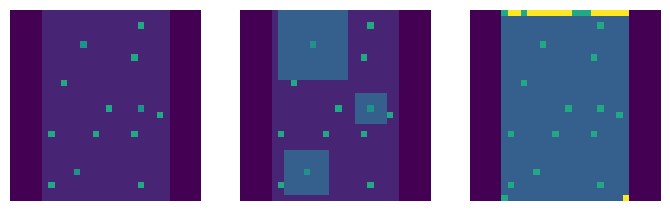

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.94s/it]


Epoch 52/500, Loss: 2.09280330390805, Accuracy: 27.39176775110389%
Epoch 53/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.03s/it]

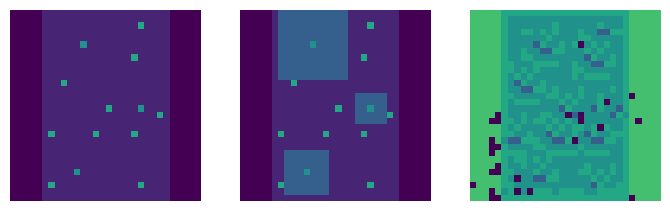

Validation: 100%|██████████| 9/9 [05:05<00:00, 33.98s/it]


Epoch 53/500, Loss: 2.1670323239732756, Accuracy: 26.534030350708015%
Epoch 54/500


Validation:  89%|████████▉ | 8/9 [04:50<00:34, 34.88s/it]

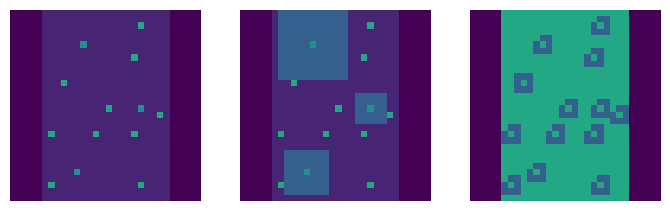

Validation: 100%|██████████| 9/9 [05:04<00:00, 33.87s/it]


Epoch 54/500, Loss: 2.132991099699016, Accuracy: 27.623204588133788%
Epoch 55/500


Validation:  89%|████████▉ | 8/9 [04:52<00:35, 35.06s/it]

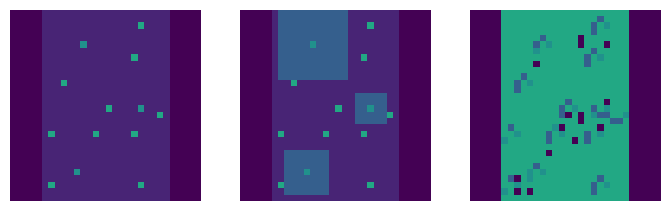

Validation: 100%|██████████| 9/9 [05:06<00:00, 34.02s/it]


Epoch 55/500, Loss: 2.1841330146305884, Accuracy: 26.277216667512562%
Epoch 56/500


Validation:  89%|████████▉ | 8/9 [04:49<00:34, 34.71s/it]

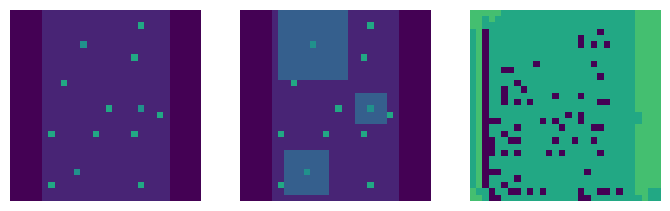

Validation: 100%|██████████| 9/9 [05:03<00:00, 33.67s/it]


Epoch 56/500, Loss: 2.266743688993067, Accuracy: 29.420900370501954%
Epoch 57/500


Validation:  89%|████████▉ | 8/9 [04:49<00:34, 34.61s/it]

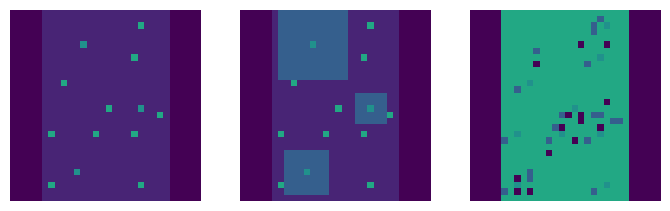

Validation: 100%|██████████| 9/9 [05:02<00:00, 33.62s/it]


Epoch 57/500, Loss: 2.125683346269808, Accuracy: 26.494442470689744%
Epoch 58/500


Validation:  89%|████████▉ | 8/9 [04:48<00:34, 34.74s/it]

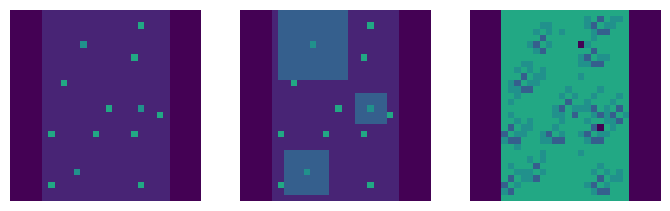

Validation: 100%|██████████| 9/9 [05:02<00:00, 33.61s/it]


Epoch 58/500, Loss: 2.1479661878651823, Accuracy: 28.685986905547377%
Epoch 59/500


Validation:  89%|████████▉ | 8/9 [04:49<00:34, 34.69s/it]

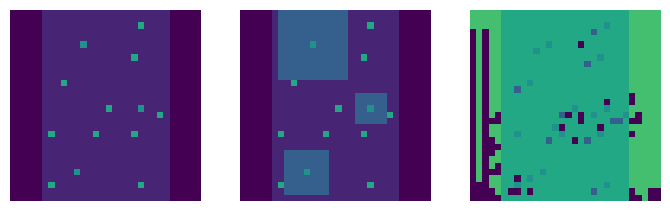

Validation: 100%|██████████| 9/9 [05:03<00:00, 33.72s/it]


Epoch 59/500, Loss: 2.1752739414963917, Accuracy: 26.057960716642135%
Epoch 60/500


Validation:  89%|████████▉ | 8/9 [04:49<00:34, 34.87s/it]

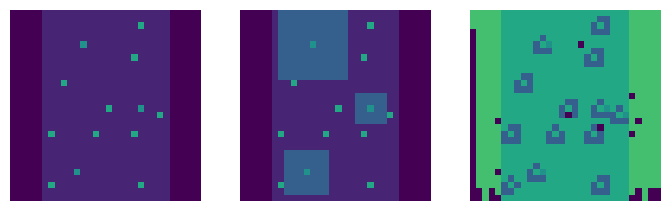

Validation: 100%|██████████| 9/9 [05:02<00:00, 33.65s/it]


Epoch 60/500, Loss: 2.125307604848343, Accuracy: 27.922651372887376%
Epoch 61/500


Validation:  89%|████████▉ | 8/9 [04:49<00:34, 34.63s/it]

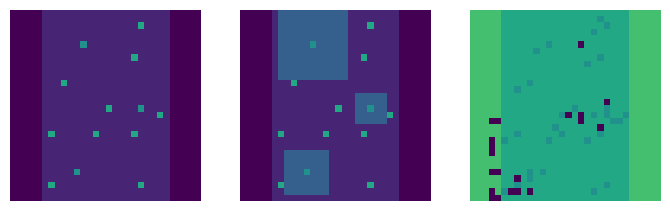

Validation: 100%|██████████| 9/9 [05:03<00:00, 33.68s/it]


Epoch 61/500, Loss: 2.1826075554463062, Accuracy: 26.940059889356952%
Epoch 62/500


Validation:  89%|████████▉ | 8/9 [04:49<00:34, 34.76s/it]

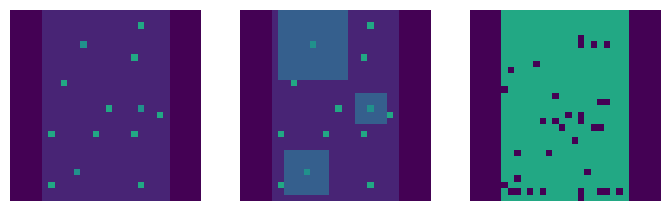

Validation: 100%|██████████| 9/9 [05:03<00:00, 33.73s/it]


Epoch 62/500, Loss: 2.1580125361609857, Accuracy: 27.422219966502563%
Epoch 63/500


Training:  78%|███████▊  | 7/9 [03:35<00:59, 29.69s/it]

In [9]:
import torch
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc



train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 500,
    'task_numbers': 50,  # equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 5,  # equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
}


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    # print(y_pred.shape, y.shape)
    weight = torch.ones(model_args['num_classes']).to(y.device)
    weight[0] = 0.05
    # weight[1] = 0.5
    ce = F.cross_entropy(y_pred, y, weight=weight)
    return ce

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True, num_workers=8)

eval_dataset = ARC_Dataset(eval_challenge, eval_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False, num_workers=8)

# Outer Model 정의
outer_model = ARC_Net(**model_args).to(device)
outer_optimizer = optim.AdamW(outer_model.parameters(), lr=kwargs['outer_lr'])

# Inner Loop 업데이트 함수
def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()

# Training Loop
for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    outer_model.train()
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            # 모델의 가중치만 복사하여 이너 모델 초기화
            inner_model = ARC_Net(**model_args).to(device)
            inner_model.load_state_dict(outer_model.state_dict())
            
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()

    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []

    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = ARC_Net(**model_args).to(device)
            inner_model.load_state_dict(outer_model.state_dict())
            
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()

                if batch_idx == len(eval_loader) - 1 and task_number == input_tensor.shape[0] - 1:
                    show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()


In [11]:
task_prediction.shape

torch.Size([1, 11, 30, 30])

In [12]:
prediction_class.shape
prediction_class

tensor([[[[1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 3, 3, 3],
          [1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3,